In [18]:
!pip install rdflib networkx matplotlib
!pip install voila

In [19]:
!pip install --upgrade traitlets


Requirement already up-to-date: traitlets in /opt/conda/lib/python3.8/site-packages (5.14.3)


In [24]:
!python --version


Python 3.8.5


In [26]:
import importlib
import pkg_resources

# Alle benutzten oder importierten Pakete hier
packages = [
    "altair", "anyio", "argon2_cffi", "argon2_cffi_bindings", "async_generator", "attrs",
    "babel", "backports.functools_lru_cache", "blinker", "Bottleneck", "brotlipy", "cachetools",
    "certifi", "certipy", "charset_normalizer", "click", "conda", "cycler", "cytoolz", "decorator",
    "defusedxml", "entrypoints", "exceptiongroup", "fastcache", "fastjsonschema", "fuzzywuzzy",
    "gitdb", "GitPython", "gmpy2", "HeapDict", "html5rdf", "importlib_metadata", "importlib_resources",
    "ipython_genutils", "ipython_sql", "isodate", "jinja2", "jsonschema", "jsonschema_specifications",
    "jupyter", "jupyter_client", "jupyter_console", "jupyter_core", "jupyter_events", "jupyter_server",
    "jupyter_server_terminals", "jupyter_telemetry", "jupyterlab", "jupyterlab_server", "kiwisolver",
    "llvmlite", "locket", "markdown_it_py", "MarkupSafe", "mdurl", "metakernel", "mistune", "mpmath",
    "msgpack", "narwhals", "nbconvert", "nbformat", "nbgrader", "numexpr", "numpy", "oauthlib",
    "olefile", "overrides", "packaging", "pamela", "pandas", "rdflib", "networkx", "matplotlib"
]

# Ausgabe der Versionen
for package in sorted(set(packages)):
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}=={version}")
    except Exception as e:
        print(f"{package} - not installed or import failed: {e}")


Bottleneck==1.3.2
GitPython==3.1.44
HeapDict==1.0.1
MarkupSafe==2.1.5
altair==5.4.1
anyio==4.5.2
argon2_cffi==23.1.0
argon2_cffi_bindings==21.2.0
async_generator==1.10
attrs==25.3.0
babel==2.17.0
backports.functools_lru_cache==1.6.1
blinker==1.4
brotlipy==0.7.0
cachetools==5.5.2
certifi==2020.6.20
certipy==0.1.3
charset_normalizer==3.4.1
click==7.1.2
conda==4.8.5
cycler==0.10.0
cytoolz==0.11.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
exceptiongroup==1.2.2
fastcache==1.1.0
fastjsonschema==2.21.1
fuzzywuzzy==0.18.0
gitdb==4.0.12
gmpy2==2.1.0b1
html5rdf==1.2.1
importlib_metadata==8.5.0
importlib_resources==6.4.5
ipython_genutils==0.2.0
ipython_sql==0.4.0
isodate==0.7.2
jinja2==3.1.6
jsonschema==4.23.0
jsonschema_specifications==2023.12.1
jupyter==1.0.0
jupyter_client==8.6.3
jupyter_console==6.2.0
jupyter_core==5.7.2
jupyter_events==0.10.0
jupyter_server==2.14.2
jupyter_server_terminals==0.5.3
jupyter_telemetry==0.0.5
jupyterlab==2.2.8
jupyterlab_server==2.27.3
kiwisolver==1.2.0

In [20]:
from rdflib import Graph, Namespace, URIRef, RDFS, RDF
import json
import os
import networkx as nx
import xml.etree.ElementTree as ET
import re  
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple
import itertools
from rdflib import Graph, Namespace, URIRef
import json
import os
import networkx as nx
import xml.etree.ElementTree as ET
from rdflib.namespace import RDFS  
from rdflib import Graph, Namespace
from rdflib.namespace import RDF
from rdflib.plugins.sparql import prepareQuery

# Query #

In [21]:
from rdflib import Graph, Namespace
from rdflib.namespace import RDF
from rdflib.plugins.sparql import prepareQuery

#load file
g = Graph()
g.parse("/home/jovyan/Thesis/swemls-instances.ttl", format="turtle")

#enough namespaces check again if missing
SWEMLS = Namespace("https://w3id.org/semsys/ns/swemls#")
RDFS = Namespace("http://www.w3.org/2000/01/rdf-schema#")


query_str = """
PREFIX swemls: <https://w3id.org/semsys/ns/swemls#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?system
WHERE {
  ?system a swemls:System .
  ?system swemls:hasCorrespondingPattern ?pattern .
  FILTER(STRENDS(STR(?pattern), "O1"))
}
"""


# lets queryy
results = g.query(query_str)

# extracting ids
matched_systems = []
for row in results:
    uri = str(row.system)
    sys_id = uri.split("/")[-1]
    matched_systems.append(sys_id)

#let the user choose
if not matched_systems:
    print(" No systems found")
    exit()

print("Matched Systems:")
for i, mas in enumerate(matched_systems):
    print(f"{i+1}: {mas}")

# Eingabe zur Auswahl
while True:
    try:
        choice = int(input("🔍 Which System do you want to see? (Type in Number): "))
        if 1 <= choice <= len(matched_systems):
            selected_system = matched_systems[choice - 1]
            break
        else:
            print("Invalid Number")
    except ValueError:
        print("Invalid Input - must be number")

print(f"\n You have choosen {selected_system}")

Matched Systems:
1: System_4YDDUZZC


🔍 Which System do you want to see? (Type in Number):  1



 You have choosen System_4YDDUZZC


In [22]:
from rdflib import Graph, Namespace, RDF, URIRef
import json

# Load the TTL file
ttl_file_path = "/home/jovyan/Thesis/swemls-instances.ttl"  # Adjust path as needed
g_instance = Graph()
g_instance.parse(ttl_file_path, format="turtle")

# Define Namespaces
SWEMLS = Namespace("https://w3id.org/semsys/ns/swemls#")
OPMW = Namespace("http://www.opmw.org/ontology#")
RDFS = Namespace("http://www.w3.org/2000/01/rdf-schema#")

# Define RDF types
rdf_type = URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")
ai_system_type = SWEMLS.System
documentation_type = SWEMLS.Documentation
paper_type = SWEMLS.Paper
ml_component_type = SWEMLS.MachineLearningComponent
kr_component_type = SWEMLS.KnowledgeRepresentationComponent
data_type = SWEMLS.Data
semantic_web_resource_type = SWEMLS.SemanticWebResource

# Define properties
has_documentation = SWEMLS.hasDocumentation
reports_on = SWEMLS.reports  # Links papers to systems
rdfs_label = RDFS.label

# Extracted AI system instances
extracted_instances = []

ai_systems = [
    system for system in g_instance.subjects(RDF.type, SWEMLS.System)
    if str(system).split("/")[-1] in matched_systems
]


# Create a dictionary to map systems to papers
system_to_paper = {}

# Iterate through all papers to find which system they report on
for paper in g_instance.subjects(predicate=rdf_type, object=paper_type):
    for reported_system in g_instance.objects(subject=paper, predicate=reports_on):
        system_id = str(reported_system).split("/")[-1]
        paper_id = str(paper).split("/")[-1]

        # Extract paper metadata
        paper_metadata = {"id": paper_id, "metadata": {}}

        for pred, obj in g_instance.predicate_objects(subject=paper):
            pred_name = pred.split("#")[-1] if "#" in pred else pred.split("/")[-1]
            paper_metadata["metadata"].setdefault(pred_name, []).append(str(obj))

        # Store in mapping
        system_to_paper.setdefault(system_id, []).append(paper_metadata)

# Iterate through AI systems and extract data

for system in ai_systems:
    if str(system).split("/")[-1] != selected_system:
        continue  # überspringe alle außer das gewählte
    instance_data = {
        "id": str(system).split("/")[-1],
        "type": "System",
        "metadata": {},
        "relationships": {},
        "documentation": {},
        "papers": [],
        "steps": [],
        "variables": {}
    }

    # Extract all properties for the AI system
    for pred, obj in g_instance.predicate_objects(subject=system):
        pred_name = pred.split("#")[-1] if "#" in pred else pred.split("/")[-1]

        if isinstance(obj, URIRef):
            instance_data["relationships"].setdefault(pred_name, []).append(str(obj).split("/")[-1])
        else:
            instance_data["metadata"][pred_name] = str(obj)

    # Extract documentation details if "hasDocumentation" relationship exists
    if "hasDocumentation" in instance_data["relationships"]:
        for doc_id in instance_data["relationships"]["hasDocumentation"]:
            doc_uri = URIRef(f"http://semantic-systems.net/swemls/{doc_id}")
            if (doc_uri, rdf_type, documentation_type) in g_instance:
                instance_data["documentation"]["id"] = doc_id
                for doc_pred, doc_obj in g_instance.predicate_objects(subject=doc_uri):
                    doc_pred_name = doc_pred.split("#")[-1] if "#" in doc_pred else doc_pred.split("/")[-1]
                    instance_data["documentation"][doc_pred_name] = str(doc_obj)

    # Attach paper details if they exist
    system_id = instance_data["id"]
    if system_id in system_to_paper:
        instance_data["papers"] = system_to_paper[system_id]

    # Extract ML and KR step details up to 10 steps
    for i in range(1, 11):
        for step_relation in [f"hasStepML{i}", f"hasStepKR{i}"]:
            if step_relation in instance_data["relationships"]:
                for step_id in instance_data["relationships"][step_relation]:
                    step_uri = URIRef(f"http://semantic-systems.net/swemls/{step_id}")
                    step_type = "Unknown"
                    if (step_uri, rdf_type, ml_component_type) in g_instance:
                        step_type = "Machine Learning"
                    elif (step_uri, rdf_type, kr_component_type) in g_instance:
                        step_type = "Knowledge Representation"
                    step_data = {"id": step_id, "type": step_type, "metadata": {}}
                    for step_pred, step_obj in g_instance.predicate_objects(subject=step_uri):
                        step_pred_name = step_pred.split("#")[-1] if "#" in step_pred else step_pred.split("/")[-1]
                        step_data["metadata"].setdefault(step_pred_name, []).append(str(step_obj))
                    instance_data["steps"].append(step_data)

    # Extract variables (Data and Symbolic Web resources) up to 10 variables
    for i in range(1, 11):
        for var_relation in [f"hasVariableData{i}", f"hasVariableSW{i}"]:
            if var_relation in instance_data["relationships"]:
                for var_id in instance_data["relationships"][var_relation]:
                    var_uri = URIRef(f"http://semantic-systems.net/swemls/{var_id}")
                    label = None
                    for _, _, label_value in g_instance.triples((var_uri, RDFS.label, None)):
                        label = str(label_value)
                        break
                    instance_data["variables"][var_relation] = {"id": var_id, "label": label}

    extracted_instances.append(instance_data)
    
#system_id = extracted_instances[0]["id"]  
json_filename = f"{selected_system}.json"

with open(json_filename, "w") as f:
    json.dump(instance_data, f, indent=4)

print(f"Saved as {json_filename}")
json_filename


Saved as System_4YDDUZZC.json


'System_4YDDUZZC.json'

In [23]:
!pip freeze > requirements.txt


# 1. Data preprocessing #

## 1.1 Loading Test file (will be updated with Query) ##

In [5]:
try:
    with open(json_filename, "r") as json_file:
            extracted_data = json.load(json_file)

    instance_data = extracted_data

    system_label = instance_data["metadata"].get("label", "no label")
    
    pattern_URI = instance_data["relationships"].get("hasCorrespondingPattern", ["no pattern"])[0]
    pattern = pattern_URI.split(".")[-1] if "Pattern." in pattern_URI else pattern_URI

    print(f" System : {system_label}")
    print(f" Pattern: {pattern}")

except FileNotFoundError:
    print(" JSON file not found! Make sure you extracted an instance first.")
except Exception as e:
    print(f" Fehler beim Verarbeiten der Datei: {e}")

 System : System 4YDDUZZC
 Pattern: O1


In [6]:
def deduplicate_ids(variables):
    seen_ids = {}
    updated_variables = {}

    for key, var in variables.items():
        original_id = var["id"]
        label = var.get("label", "")

        if original_id in seen_ids:
            seen_ids[original_id] += 1
            new_id = f"{original_id}_{seen_ids[original_id]}"
        else:
            seen_ids[original_id] = 1
            new_id = original_id

        updated_variables[key] = {
            "id": new_id,
            "label": label
        }

    return updated_variables
# IDs in variables deduplizieren
instance_data["variables"] = deduplicate_ids(instance_data.get("variables", {}))


## 1.2 Load and extract Pattern information (will be updated) ##

In [7]:
ttl_file_path = "/home/jovyan/Thesis/Shapes_Patterns/O1-pattern.ttl"
g = Graph()
g.parse(ttl_file_path, format="turtle")

# Define namespaces
SWEMLS = Namespace("https://w3id.org/semsys/ns/swemls#")
OPMW = Namespace("http://www.opmw.org/ontology/")
RES = Namespace("http://semantic-systems.net/swemls/")

# Initialize data structure
pattern_structure = {
    "steps": {},
    "variables": {}
}

# Function to clean URIs and remove prefixes dynamically
def clean_uri(uri):
    label = uri.split("/")[-1].split("#")[-1]  # Extract last part after '/' or '#'

    # Remove "Pattern.<prefix>." and any "<prefix>." that follows it
    label = re.sub(r'Pattern\.[A-Za-z0-9]+\.', '', label)  # Removes Pattern.XY.
    label = re.sub(r'^[A-Za-z0-9]+\.', '', label)  # Removes remaining XY.

    return label

# ✅ Extract Workflow Template Processes (ML and KR steps)
for step in g.subjects(RDF.type, SWEMLS.WorkflowTemplateProcessML):
    step_label = clean_uri(str(step))
    inputs = [clean_uri(str(var)) for var in g.objects(step, OPMW["uses"])]
    pattern_structure["steps"][step_label] = {"type": "ML", "uses": inputs, "outputs": []}

for step in g.subjects(RDF.type, SWEMLS.WorkflowTemplateProcessKR):
    step_label = clean_uri(str(step))
    inputs = [clean_uri(str(var)) for var in g.objects(step, OPMW["uses"])]
    pattern_structure["steps"][step_label] = {"type": "KR", "uses": inputs, "outputs": []}

# ✅ Also check RES namespace for ML and KR steps
for step in g.subjects(RDF.type, RES.WorkflowTemplateProcessML):
    step_label = clean_uri(str(step))
    inputs = [clean_uri(str(var)) for var in g.objects(step, OPMW["uses"])]
    pattern_structure["steps"][step_label] = {"type": "ML", "uses": inputs, "outputs": []}

for step in g.subjects(RDF.type, RES.WorkflowTemplateProcessKR):
    step_label = clean_uri(str(step))
    inputs = [clean_uri(str(var)) for var in g.objects(step, OPMW["uses"])]
    pattern_structure["steps"][step_label] = {"type": "KR", "uses": inputs, "outputs": []}

# ✅ Extract Data and Symbolic Variables, handling multiple generators
for var in g.subjects(RDF.type, SWEMLS.TemplateArtifactData):
    var_label = clean_uri(str(var))
    generated_by = [clean_uri(str(gen)) for gen in g.objects(var, OPMW["isGeneratedBy"])]

    # Ensure all steps that generate this variable correctly receive it as an output
    for gen in generated_by:
        if gen in pattern_structure["steps"]:
            pattern_structure["steps"][gen]["outputs"].append(var_label)

    # Store the variable with all its generating steps
    pattern_structure["variables"][var_label] = {"generated_by": generated_by} if generated_by else {}

# ✅ Also check RES namespace for TemplateArtifactData
for var in g.subjects(RDF.type, RES.TemplateArtifactData):
    var_label = clean_uri(str(var))
    generated_by = [clean_uri(str(gen)) for gen in g.objects(var, OPMW["isGeneratedBy"])]

    for gen in generated_by:
        if gen in pattern_structure["steps"]:
            pattern_structure["steps"][gen]["outputs"].append(var_label)

    pattern_structure["variables"][var_label] = {"generated_by": generated_by} if generated_by else {}

# ✅ Extract Symbolic Variables
for var in g.subjects(RDF.type, SWEMLS.TemplateArtifactSW):
    var_label = clean_uri(str(var))
    generated_by = [clean_uri(str(gen)) for gen in g.objects(var, OPMW["isGeneratedBy"])]

    for gen in generated_by:
        if gen in pattern_structure["steps"]:
            pattern_structure["steps"][gen]["outputs"].append(var_label)

    pattern_structure["variables"][var_label] = {"generated_by": generated_by} if generated_by else {}

# ✅ Also check RES namespace for TemplateArtifactSW
for var in g.subjects(RDF.type, RES.TemplateArtifactSW):
    var_label = clean_uri(str(var))
    generated_by = [clean_uri(str(gen)) for gen in g.objects(var, OPMW["isGeneratedBy"])]

    for gen in generated_by:
        if gen in pattern_structure["steps"]:
            pattern_structure["steps"][gen]["outputs"].append(var_label)

    pattern_structure["variables"][var_label] = {"generated_by": generated_by} if generated_by else {}

### 1.2.1 Print Pattern Structure ###

In [8]:
 #Print the extracted pattern structure (without prefixes)
print(json.dumps(pattern_structure, indent=4))

{
    "steps": {
        "ML1": {
            "type": "ML",
            "uses": [
                "Data1"
            ],
            "outputs": [
                "Data2"
            ]
        },
        "ML2": {
            "type": "ML",
            "uses": [
                "Data3"
            ],
            "outputs": [
                "Data4",
                "SW1"
            ]
        },
        "ML3": {
            "type": "ML",
            "uses": [
                "Data5"
            ],
            "outputs": [
                "Data6"
            ]
        },
        "ML4": {
            "type": "ML",
            "uses": [
                "Data2",
                "Data4",
                "Data6"
            ],
            "outputs": [
                "Data7"
            ]
        },
        "KR1": {
            "type": "KR",
            "uses": [
                "Data1",
                "SW1",
                "SW2"
            ],
            "outputs": [
                "Data5"

## 1.3 Components mapping ## 

In [9]:
import re

# ✅ Helper: Extract short label from step metadata (e.g., extract "w2v" from "HUS3CVRH-ML1 (w2v)")
def extract_label_short(step):
    labels = step.get("metadata", {}).get("label", [])
    if labels:
        match = re.search(r"\((.*?)\)", labels[0])
        if match:
            return match.group(1)  # e.g., "w2v"
    # Fallback: last part of ID
    return step["id"].split(".")[-1]

# ✅ Initialize JSON to Pattern Mapping
json_to_pattern_map = {}

# ✅ Ensure ALL ML and KR steps are mapped correctly (using labels)
for step in instance_data["steps"]:
    step_key = step["id"].split(".")[-1]  # e.g., "ML1"
    step_label = extract_label_short(step)  # e.g., "w2v"
    json_to_pattern_map[step_key] = step_label  # e.g., "ML1" → "w2v"

# ✅ Ensure ALL data & symbolic variables are mapped correctly
for var_key, var_data in instance_data["variables"].items():
    json_to_pattern_map[var_key] = var_data["id"]  # Direct mapping (e.g., "D1" → "HUS3CVRH.D1")

# ✅ Ensure unique mappings for data and SW variables (avoiding overwrites)
for var_data in instance_data["variables"].values():
    key = var_data["id"].split(".")[-1]
    if key not in json_to_pattern_map:  # ✅ Prevent overriding existing mappings
        json_to_pattern_map[key] = var_data["id"]

# ✅ Initialize Components Dictionary
components = {
    "ml_component": [],
    "kr_component": [],
    "data": [],
    "symbolic_data": []
}

# ✅ Add ML and KR steps to components (keep using full ID as internal reference)
for step in instance_data["steps"]:
    step_type = step["metadata"]["type"][-1]  # Get last type entry

    if step["id"] not in components["ml_component"] and "MachineLearningComponent" in step_type:
        components["ml_component"].append(step["id"])

    elif step["id"] not in components["kr_component"] and "KnowledgeRepresentationComponent" in step_type:
        components["kr_component"].append(step["id"]) 

# ✅ Categorize variables into data and symbolic data
for var_relation, var_data in instance_data["variables"].items():
    if "SW" in var_relation:
        components["symbolic_data"].append(var_data["id"])
    else:
        components["data"].append(var_data["id"])

# ✅ Ensure missing nodes from instance JSON are added to pattern structure
for key in set(json_to_pattern_map.keys()) - set(pattern_structure["variables"].keys()):
    pattern_structure["variables"][key] = {"generated_by": []}  # Ensure structure consistency

# ✅ Re-check missing nodes before edge creation
missing_nodes = set(json_to_pattern_map.keys()) - set(pattern_structure["variables"].keys()) - set(pattern_structure["steps"].keys())
if missing_nodes:
    print(f" ⚠️ WARNING: Nodes still missing after fix: {missing_nodes}")


### Using Template ###

In [ ]:
import xml.etree.ElementTree as ET
import re

def extract_label_short(step):
    labels = step.get("metadata", {}).get("label", [])
    if labels:
        match = re.search(r"\((.*?)\)", labels[0])
        if match:
            return match.group(1)
    return step["id"].split(".")[-1]

def replace_pattern_placeholders(xml_string, instance_data, pattern_structure):
    tree = ET.ElementTree(ET.fromstring(xml_string))
    root = tree.getroot()

    replacements = {}

    # ✅ ML/KR steps → nur Label (z. B. Compound)
    for step in instance_data.get("steps", []):
        step_key = step["id"].split(".")[-1]  # e.g., ML1
        step_label = extract_label_short(step)
        replacements[step_key] = step_label

    # ✅ SW / Data Variablen → mit SW1 / Data1 aus pattern_structure verknüpfen
    for pattern_var in pattern_structure.get("variables", {}):
        # Hole die Instanz-ID über Matching
        for var_key, var_data in instance_data.get("variables", {}).items():
            if pattern_var.lower() in var_key.lower():
                inst_id = var_data["id"].replace("Resource.", "").replace("Custom.", "")
                replacements[pattern_var] = inst_id
                break

    print("\n🧩 Mapping for replacements:")
    for k, v in replacements.items():
        print(f"  {k} → {v}")

    for element in root.iter("mxCell"):
        if 'value' in element.attrib:
            value = element.attrib['value']
            for placeholder, real_value in replacements.items():
                if placeholder in value:
                    replacement = real_value.replace("_", " ") if real_value.strip() else "Missing"

                    # Schriftgröße anpassen
                    style = element.attrib.get("style", "")
                    length = len(replacement)
                    if length > 24:
                        style += ";fontSize=5"
                    elif length > 20:
                        style += ";fontSize=7"
                    elif length > 17:
                        style += ";fontSize=9"
                    element.attrib['style'] = style

                    element.attrib['value'] = value.replace(placeholder, replacement)

    return ET.tostring(root, encoding='utf8', method='xml').decode()
with open("/home/jovyan/Thesis/Templates/O1.xml", "r", encoding="utf-8") as f:
    xml_template = f.read()

updated_xml = replace_pattern_placeholders(xml_template, instance_data, pattern_structure)

with open("/home/jovyan/Thesis/Updated_O1_Workflow.xml", "w", encoding="utf-8") as f:
    f.write(updated_xml)


### 1.3.1 Print Components ###

In [10]:
print("\n DEBUG: Final JSON to Pattern Mapping:", json.dumps(json_to_pattern_map, indent=4))
print("\n DEBUG: Final Pattern Structure Variables:", pattern_structure["variables"].keys())
print("\n DEBUG: Components Breakdown:", json.dumps(components, indent=4))


 DEBUG: Final JSON to Pattern Mapping: {
    "ML1": "Compound",
    "KR1": "SPARQL",
    "ML2": "CNN",
    "ML3": "Compound",
    "ML4": "MCAN",
    "hasVariableData1": "Custom.4YDDUZZC.d1",
    "hasVariableSW1": "Custom.4YDDUZZC.sw1",
    "hasVariableData2": "Custom.4YDDUZZC.d2",
    "hasVariableSW2": "Resource.ConceptNet",
    "hasVariableData3": "Custom.4YDDUZZC.d3",
    "hasVariableData4": "Custom.4YDDUZZC.d4",
    "hasVariableData5": "Custom.4YDDUZZC.d5",
    "hasVariableData6": "Custom.4YDDUZZC.d6",
    "hasVariableData7": "Custom.4YDDUZZC.d7",
    "d1": "Custom.4YDDUZZC.d1",
    "sw1": "Custom.4YDDUZZC.sw1",
    "d2": "Custom.4YDDUZZC.d2",
    "ConceptNet": "Resource.ConceptNet",
    "d3": "Custom.4YDDUZZC.d3",
    "d4": "Custom.4YDDUZZC.d4",
    "d5": "Custom.4YDDUZZC.d5",
    "d6": "Custom.4YDDUZZC.d6",
    "d7": "Custom.4YDDUZZC.d7"
}

 DEBUG: Final Pattern Structure Variables: dict_keys(['Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'SW1', 'SW2', 'hasVariab

## 1.4 Mapping Edges ##

In [11]:
# ✅ Ensure 'edges' is defined before clearing
edges = []  # Initialize edges as an empty list

# ✅ Reset edges list before appending new edges
edges.clear()  # Ensure no duplicates from previous runs

# ✅ Dynamically generate mappings for up to Data10 and SW10
special_mappings = {f"Data{i}": f"hasVariableData{i}" for i in range(1, 11)}
special_mappings.update({f"SW{i}": f"hasVariableSW{i}" for i in range(1, 11)})

# ✅ Initialize JSON to Pattern Mapping
json_to_pattern_map = {}

# ✅ Ensure ALL ML and KR steps are mapped correctly
for step in instance_data["steps"]:
    step_key = step["id"].split(".")[-1]  # Extract last part of the ID
    json_to_pattern_map[step_key] = step["id"]  # Map short name to full ID

# ✅ Ensure ALL data & symbolic variables are mapped correctly
for var_key, var_data in instance_data["variables"].items():
    json_to_pattern_map[var_key] = var_data["id"]  # Direct mapping

# ✅ Ensure missing nodes from instance JSON are correctly mapped to pattern variables
for var_name in pattern_structure["variables"]:
    if var_name not in json_to_pattern_map:
        found_match = False

        # ✅ First, check if pattern variables like "Data1" have a corresponding instance variable (hasVariableData1)
        if var_name in special_mappings:
            mapped_var = instance_data["variables"].get(special_mappings[var_name], {}).get("id")
            if mapped_var:
                json_to_pattern_map[var_name] = mapped_var
                found_match = True

        # ✅ Direct match with instance variables
        if not found_match:
            for var_key, var_data in instance_data["variables"].items():
                if var_name.lower() in var_key.lower():  # More flexible matching
                    json_to_pattern_map[var_name] = var_data["id"]
                    found_match = True
                    break

        # ✅ Check if variable exists in instance_data["relationships"]
        if not found_match:
            for rel_key, rel_values in instance_data["relationships"].items():
                if isinstance(rel_values, list):
                    for value in rel_values:
                        if var_name.lower() == value.split(".")[-1].lower():
                            json_to_pattern_map[var_name] = value
                            found_match = True
                            break
                if found_match:
                    break

        # ✅ Fallback if no match found
        if not found_match:
            json_to_pattern_map[var_name] = var_name  # Default to itself

# ✅ Debugging: Verify that all variables and steps are mapped correctly
#print("\n📌 DEBUG: Updated JSON to Pattern Mapping (after fixing variable linking):")
#print(json.dumps(json_to_pattern_map, indent=4))

# ✅ Generate edges based on the fixed pattern structure
for step, relations in pattern_structure["steps"].items():
    step_real_id = json_to_pattern_map.get(step, step)

    for used in relations.get("uses", []):
        used_real_id = json_to_pattern_map.get(used, used)

        # ✅ Prevent missing edges due to missing nodes
        if used_real_id in json_to_pattern_map.values() and used_real_id in json_to_pattern_map.values():
            edges.append((used_real_id, step_real_id))
        else:
            print(f"❌ ERROR: Missing node in mapping - {used} ({used_real_id})")

    for output in relations.get("outputs", []):
        output_real_id = json_to_pattern_map.get(output, output)

        # ✅ Prevent missing edges due to missing nodes
        if output_real_id in json_to_pattern_map.values() and output_real_id in json_to_pattern_map.values():
            edges.append((step_real_id, output_real_id))
        else:
            print(f"❌ ERROR: Missing node in mapping - {output} ({output_real_id})")

# ✅ Debugging Outputs
print(f"\nFinal Edge List: {edges}")

# ✅ Check for unlinked nodes
all_edge_nodes = {node for edge in edges for node in edge}
unlinked_nodes = set(json_to_pattern_map.values()) - all_edge_nodes
if unlinked_nodes:
    print(f" WARNING: Some nodes are in the mapping but not used in edges: {unlinked_nodes}")


Final Edge List: [('Custom.4YDDUZZC.d1', '4YDDUZZC.ML1'), ('4YDDUZZC.ML1', 'Custom.4YDDUZZC.d2'), ('Custom.4YDDUZZC.d3', '4YDDUZZC.ML2'), ('4YDDUZZC.ML2', 'Custom.4YDDUZZC.d4'), ('4YDDUZZC.ML2', 'Custom.4YDDUZZC.sw1'), ('Custom.4YDDUZZC.d5', '4YDDUZZC.ML3'), ('4YDDUZZC.ML3', 'Custom.4YDDUZZC.d6'), ('Custom.4YDDUZZC.d2', '4YDDUZZC.ML4'), ('Custom.4YDDUZZC.d4', '4YDDUZZC.ML4'), ('Custom.4YDDUZZC.d6', '4YDDUZZC.ML4'), ('4YDDUZZC.ML4', 'Custom.4YDDUZZC.d7'), ('Custom.4YDDUZZC.d1', '4YDDUZZC.KR1'), ('Custom.4YDDUZZC.sw1', '4YDDUZZC.KR1'), ('Resource.ConceptNet', '4YDDUZZC.KR1'), ('4YDDUZZC.KR1', 'Custom.4YDDUZZC.d5')]


# 2 Positioning Algorithm #

## 2.1 Assignings Ranks ##

In [12]:
def assign_ranks_with_limited_correction(components, edges):
    print("🔧 Starte Topological Rank Assignment mit begrenzter Korrektur (nur bei Knoten ohne Vorgänger)...\n")

    # Schritt 1: Graph konstruieren
    G = nx.DiGraph()
    G.add_edges_from(edges)

    if not nx.is_directed_acyclic_graph(G):
        print("❌ Fehler: Der Graph enthält einen Zyklus.")
        return None

    topo_order = list(nx.topological_sort(G))

    # Schritt 2: Initiale Rangzuweisung
    rank_map = {}
    for node in topo_order:
        preds = list(G.predecessors(node))
        if not preds:
            rank_map[node] = 0
        else:
            rank_map[node] = max(rank_map[p] + 1 for p in preds)

    print("🎯 Vorläufige Ränge:")
    for node, rank in rank_map.items():
        print(f"  {node}: Rang {rank}")

    # Schritt 3: Korrektur nur für Knoten ohne Vorgänger
    print("\n🔁 Starte begrenzte Shared-Input-Korrektur für Knoten ohne Vorgänger...")
    all_targets = defaultdict(list)
    for source, target in edges:
        all_targets[source].append(target)

    for node, targets in all_targets.items():
        if list(G.predecessors(node)):  # Skip nodes with predecessors
            continue

        candidate_ranks = []
        for target in targets:
            target_rank = rank_map.get(target, 1)
            candidate_ranks.append(target_rank - 1)

        if candidate_ranks:
            new_rank = min(candidate_ranks)
            if new_rank >= 0 and new_rank != rank_map[node]:
                print(f"  🔁 Korrektur: {node} von Rang {rank_map[node]} → {new_rank} (basierend auf {len(candidate_ranks)} Targets)")
                rank_map[node] = new_rank

    # Schritt 4: Gruppierung nach Rängen
    grouped = defaultdict(list)
    for node, rank in rank_map.items():
        grouped[rank].append(node)

    print("\n📊 Final zugewiesene Ränge nach Korrektur:")
    for rank in sorted(grouped):
        print(f"  Rang {rank}: {grouped[rank]}")

    return rank_map

rank_map = assign_ranks_with_limited_correction(components, edges)

🔧 Starte Topological Rank Assignment mit begrenzter Korrektur (nur bei Knoten ohne Vorgänger)...

🎯 Vorläufige Ränge:
  Resource.ConceptNet: Rang 0
  Custom.4YDDUZZC.d3: Rang 0
  4YDDUZZC.ML2: Rang 1
  Custom.4YDDUZZC.sw1: Rang 2
  Custom.4YDDUZZC.d4: Rang 2
  Custom.4YDDUZZC.d1: Rang 0
  4YDDUZZC.KR1: Rang 3
  Custom.4YDDUZZC.d5: Rang 4
  4YDDUZZC.ML3: Rang 5
  Custom.4YDDUZZC.d6: Rang 6
  4YDDUZZC.ML1: Rang 1
  Custom.4YDDUZZC.d2: Rang 2
  4YDDUZZC.ML4: Rang 7
  Custom.4YDDUZZC.d7: Rang 8

🔁 Starte begrenzte Shared-Input-Korrektur für Knoten ohne Vorgänger...
  🔁 Korrektur: Resource.ConceptNet von Rang 0 → 2 (basierend auf 1 Targets)

📊 Final zugewiesene Ränge nach Korrektur:
  Rang 0: ['Custom.4YDDUZZC.d3', 'Custom.4YDDUZZC.d1']
  Rang 1: ['4YDDUZZC.ML2', '4YDDUZZC.ML1']
  Rang 2: ['Resource.ConceptNet', 'Custom.4YDDUZZC.sw1', 'Custom.4YDDUZZC.d4', 'Custom.4YDDUZZC.d2']
  Rang 3: ['4YDDUZZC.KR1']
  Rang 4: ['Custom.4YDDUZZC.d5']
  Rang 5: ['4YDDUZZC.ML3']
  Rang 6: ['Custom.4YDDUZZC

## 2.2 Layering nodes within ranks ###

In [13]:
def count_crossings(layers: Dict[int, List[str]], edges: List[Tuple[str, str]]) -> int:
    pos_in_layer = {node: (rank, i) for rank, nodes in layers.items() for i, node in enumerate(nodes)}
    crossings = 0
    for (u1, v1), (u2, v2) in itertools.combinations(edges, 2):
        if u1 not in pos_in_layer or v1 not in pos_in_layer or u2 not in pos_in_layer or v2 not in pos_in_layer:
            continue
        r1_u, x1_u = pos_in_layer[u1]
        r1_v, x1_v = pos_in_layer[v1]
        r2_u, x2_u = pos_in_layer[u2]
        r2_v, x2_v = pos_in_layer[v2]
        if r1_v != r2_v:
            continue  # Only compare edges in the same layer
        if (x1_u - x2_u) * (x1_v - x2_v) < 0:
            crossings += 1
    return crossings

def greedy_swap_optimization(layers: Dict[int, List[str]], edges: List[Tuple[str, str]], iterations: int = 10) -> Dict[int, List[str]]:
    G = nx.DiGraph()
    G.add_edges_from(edges)
    new_layers = {r: list(nodes) for r, nodes in layers.items()}  # Copy
    print("\n🔁 Starte Greedy-Swap Optimierung...\n")
    for r in sorted(new_layers):
        if r == 0:
            continue  # Don't optimize layer 0
        improved = True
        while improved:
            improved = False
            current = new_layers[r]
            for i in range(len(current) - 1):
                swapped = list(current)
                swapped[i], swapped[i+1] = swapped[i+1], swapped[i]
                temp_layers = dict(new_layers)
                temp_layers[r] = swapped
                old_crossings = count_crossings(new_layers, edges)
                new_crossings = count_crossings(temp_layers, edges)
                if new_crossings < old_crossings:
                    print(f"  ✅ Swap: {current[i]} ⬌ {current[i+1]} reduziert Kreuzungen: {old_crossings} → {new_crossings}")
                    new_layers[r] = swapped
                    improved = True
                    break
    return new_layers

def apply_median_heuristic(rank_map: Dict[str, int], edges: List[Tuple[str, str]], sort_layer_0: bool = False) -> Dict[int, List[str]]:
    print("\n🔧 Starte Median-Heuristik zur Anordnung der Knoten innerhalb von Rängen...\n")
    layers = defaultdict(list)
    for node, rank in rank_map.items():
        layers[rank].append(node)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    ordered_layers = {}
    for r in sorted(layers.keys()):
        if r == 0 and not sort_layer_0:
            ordered_layers[r] = layers[r]
            continue
        def median(node):
            preds = list(G.predecessors(node))
            if not preds:
                return float('inf')
            return sum([layers[rank_map[pred]].index(pred) for pred in preds if pred in layers[rank_map[pred]]]) / len(preds)
        sorted_nodes = sorted(layers[r], key=median)
        ordered_layers[r] = sorted_nodes
    print("📊 Ergebnis der Median-Heuristik:")
    for rank in sorted(ordered_layers):
        print(f"  Rang {rank}: {ordered_layers[rank]}")
    return ordered_layers

def plot_graph_layout(edges: List[Tuple[str, str]], rank_map: Dict[str, int], layer_nodes: Dict[int, List[str]], title: str = "Graph Layout") -> None:
    pos = {}
    x_spacing = 2
    y_spacing = 2
    for r, nodes in sorted(layer_nodes.items()):
        for i, node in enumerate(nodes):
            pos[node] = (i * x_spacing, -r * y_spacing)
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrows=True)
    plt.title(title)
    plt.axis('off')
    plt.show()

### 2.2.1 Plotting unordered within ranks ###

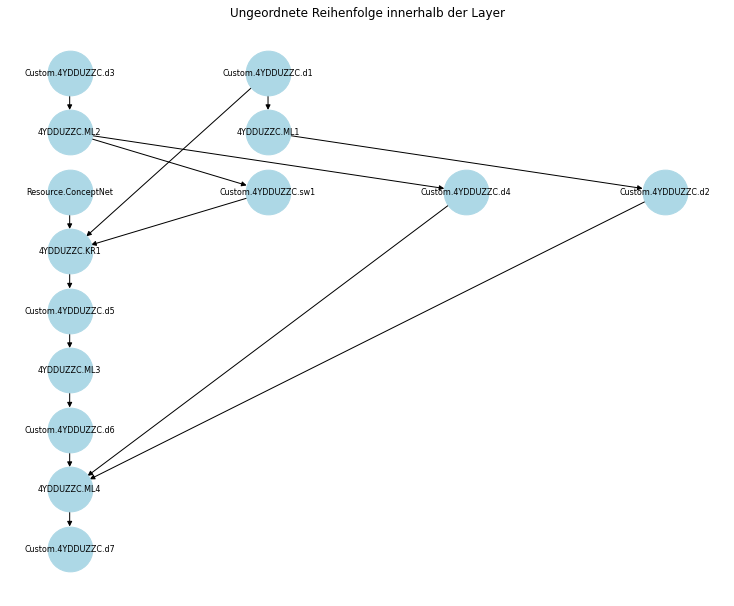

In [14]:
unordered_layers = defaultdict(list)
for node, rank in rank_map.items():
    unordered_layers[rank].append(node)


plot_graph_layout(edges, rank_map, unordered_layers, title="Ungeordnete Reihenfolge innerhalb der Layer")

### 2.2.2 Plotting and applying median heuristik ###


🔧 Starte Median-Heuristik zur Anordnung der Knoten innerhalb von Rängen...

📊 Ergebnis der Median-Heuristik:
  Rang 0: ['Custom.4YDDUZZC.d3', 'Custom.4YDDUZZC.d1']
  Rang 1: ['4YDDUZZC.ML2', '4YDDUZZC.ML1']
  Rang 2: ['Custom.4YDDUZZC.sw1', 'Custom.4YDDUZZC.d4', 'Custom.4YDDUZZC.d2', 'Resource.ConceptNet']
  Rang 3: ['4YDDUZZC.KR1']
  Rang 4: ['Custom.4YDDUZZC.d5']
  Rang 5: ['4YDDUZZC.ML3']
  Rang 6: ['Custom.4YDDUZZC.d6']
  Rang 7: ['4YDDUZZC.ML4']
  Rang 8: ['Custom.4YDDUZZC.d7']


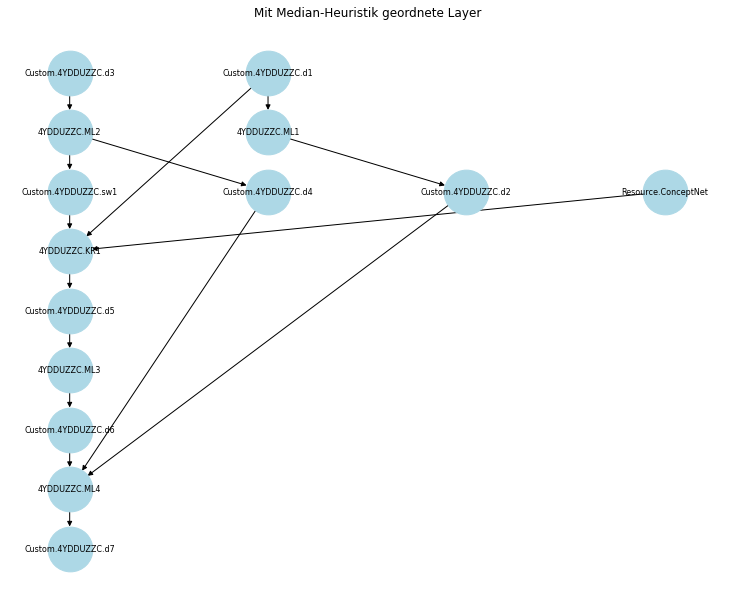

In [15]:
ordered_layers = apply_median_heuristic(rank_map, edges, sort_layer_0=True)
plot_graph_layout(edges, rank_map, ordered_layers, title="Mit Median-Heuristik geordnete Layer")

### 2.2.3.Applying and plotting greedy swap ###

In [ ]:
optimized_layers = greedy_swap_optimization(ordered_layers, edges)
plot_graph_layout(edges, rank_map, optimized_layers, title=" Optimiert mit Greedy-Swap nach Median-Heuristik")

## 2.3 Assigning coordinates ##

In [ ]:
def assign_coordinates(ordered_layers: Dict[int, List[str]], x_spacing: int = 200, y_spacing: int = 150) -> Dict[str, Tuple[int, int]]:
    positions = {}
    for rank in sorted(ordered_layers):
        nodes = ordered_layers[rank]
        for i, node in enumerate(nodes):
            x = i * x_spacing
            y = rank * y_spacing  
            positions[node] = (x, y)
    return positions

positions = assign_coordinates(optimized_layers)

positions

In [ ]:
def shift_with_cascade(pos_to_node, positions, x, y, shift_x):
    """
    Versucht, (x, y) zu belegen – wenn dort schon ein Node ist, wird er nach rechts verschoben,
    inkl. Kaskade für weitere Blockaden.
    """
    if (x, y) not in pos_to_node:
        return x  # Kein Problem – Platz ist frei

    # Es gibt bereits einen Node hier → verschiebe ihn nach rechts
    blocked_node = pos_to_node[(x, y)]
    new_x = shift_with_cascade(pos_to_node, positions, x + shift_x, y, shift_x)

    print(f"  🔁 Kollision: {blocked_node} ist auf ({x}, {y}) → verschiebe nach ({new_x}, {y})")
    positions[blocked_node] = (new_x, y)
    pos_to_node[(new_x, y)] = blocked_node
    del pos_to_node[(x, y)]  # alte Position freigeben

    return x  # Jetzt kann der ursprüngliche Node an diese Stelle

def simple_overlap_correction(positions, edges, x_spacing=200, shift_x=200):
    print("\n🧠 Starte finalen Überlappungs-Check mit Shift-Kaskade...")

    pos_to_node = {(x, y): node for node, (x, y) in positions.items()}
    x_to_y = defaultdict(list)
    for (x, y), node in pos_to_node.items():
        x_to_y[x].append((y, node))

    corrections = {}

    for source, target in edges:
        if source not in positions or target not in positions:
            continue

        x1, y1 = positions[source]
        x2, y2 = positions[target]

        if x1 == x2 and abs(y1 - y2) > 1:
            y_min, y_max = sorted([y1, y2])
            for y_mid, middle_node in x_to_y[x1]:
                if y_min < y_mid < y_max:
                    print(f"⚠️ Überlappung erkannt bei Kante {source} → {target} durch {middle_node} auf X={x1}, Y={y_mid}")
                    
                    if target not in corrections:
                        # Jetzt: Berechne neue X-Position mit Kaskade
                        new_x = shift_with_cascade(pos_to_node, positions, x1 + shift_x, y2, shift_x)
                        corrections[target] = (new_x, y2)
                    break

    for node, (new_x, new_y) in corrections.items():
        print(f"➡️ Verschiebe Node {node} nach rechts auf X={new_x}")
        positions[node] = (new_x, new_y)
        pos_to_node[(new_x, new_y)] = node

    if not corrections:
        print("✅ Keine Überlappungen erkannt – keine Verschiebungen nötig.")
    else:
        print("✅ Überlappungs-Korrektur (mit Kaskade) abgeschlossen.")

    return positions




positions = assign_coordinates(optimized_layers)  # ← Basierend auf optimierten Layern
positions = simple_overlap_correction(positions, edges)  # ← Neuer finaler Fix



# 3.Creating XML # 

## 3.1 Final checks ## 

In [ ]:
# ✅ Dynamically create node_aliases from instance_data
node_aliases = {}

# ✅ Ensure ML, KR, and SR steps are mapped
for step in instance_data["steps"]:
    short_id = step["id"].split(".")[-1]
    node_aliases[short_id] = step["id"]
    node_aliases[step["id"]] = step["id"]  # Ensure full ID is also mapped

# ✅ Ensure ALL variables (symbolic + data) are mapped
for var_key, var_data in instance_data["variables"].items():
    node_aliases[var_key] = var_data["id"]
    node_aliases[var_data["id"]] = var_data["id"]  # Ensure full ID mapping

#print("\n📌 DEBUG: Final Node Alias Mapping:", json.dumps(node_aliases, indent=4))

# ✅ Final validation before calling function
all_edge_nodes = {node for edge in edges for node in edge}
all_component_nodes = set(node for nodes in components.values() for node in nodes)

if "unclassified" in components:
    components["unclassified"] = [
        node for node in components["unclassified"]
        if node not in node_aliases and node not in node_aliases.values()
    ]
    print("\n🚀 DEBUG: Cleaned 'unclassified' category to remove duplicates:", components["unclassified"])

label_map = {}

for step in instance_data["steps"]:
    full_id = step["id"]  # e.g., HUS3CVRH.ML1
    short_label = extract_label_short(step)  # e.g., "w2v"
    label_map[full_id] = short_label


## 3.2 Generate Workflow XML ##

In [ ]:
def generate_drawio_xml(positions, components, edges, label_map=None):
    print("\n🔹 FUNCTION CALLED: generate_drawio_xml")

    mxfile = ET.Element("mxfile", host="Electron", version="26.0.16")
    diagram = ET.SubElement(mxfile, "diagram", name="Generated Workflow")
    mxGraphModel = ET.SubElement(diagram, "mxGraphModel", dx="913", dy="789", grid="0", gridSize="10", 
                                 guides="1", tooltips="1", connect="1", arrows="1", fold="1", page="1", 
                                 pageScale="1", pageWidth="827", pageHeight="1169", background="none", 
                                 math="0", shadow="0")
    root = ET.SubElement(mxGraphModel, "root")

    # Draw.io root cells
    ET.SubElement(root, "mxCell", id="0")
    ET.SubElement(root, "mxCell", id="1", parent="0")

    styles = {
        "data": "shape=hexagon;fillColor=#CCCCCC;strokeColor=#999999;",
        "symbolic_data": "shape=hexagon;fillColor=#B9E0A5;strokeColor=#009900;",
        "ml_component": "shape=rectangle;fillColor=#00FFFF;strokeColor=#66B2FF;",
        "sr_component": "shape=rectangle;fillColor=#00FF00;strokeColor=#008000;",
        "kr_component": "shape=rectangle;fillColor=#00FF00;strokeColor=#008000;",
        "unclassified": "shape=ellipse;fillColor=#FFA07A;strokeColor=#FF4500;"
    }

    node_elements = {}

    print("\n📌 DEBUG: Components received in function:")
    for category, nodes in components.items():
        print(f"  - {category}: {nodes}")

    for category, nodes in components.items():
        for node in nodes:
            style = styles.get(category, "shape=ellipse;")

            # 🆕 Neu: Wenn label_map vorhanden und Node bekannt ist, nutze das lesbare Label
            if label_map and node in label_map:
                cleaned_name = label_map[node]
            else:
                cleaned_name = node.replace("Custom.", "").replace("Resource.", "")

            length = len(cleaned_name)
            if length > 24:
                style += "fontSize=5"
            elif length > 20:
                style += "fontSize=7;"
            elif length > 17:
                style += "fontSize=9;"

            pos = positions.get(node, (100, 100))
            mxCell = ET.SubElement(root, "mxCell", id=node, value=cleaned_name, style=style, vertex="1", parent="1")
            mxGeometry = ET.SubElement(mxCell, "mxGeometry", x=str(pos[0]), y=str(pos[1]), width="120", height="80")
            mxGeometry.set("as", "geometry")

            node_elements[node] = node

    print("\n📌 DEBUG: Checking node elements before edge creation:", node_elements.keys())
    print("\n📌 DEBUG: Edges list inside function (before alias replacement):", edges)

    updated_edges = []
    for source, target in edges:
        new_source = node_aliases.get(source, source)
        new_target = node_aliases.get(target, target)
        updated_edges.append((new_source, new_target))

    edges = updated_edges

    print("\n📌 DEBUG: Reached edge processing loop...")

    for source, target in edges:
        print(f"  🔍 DEBUG: Processing edge {source} → {target}")
        if source in node_elements and target in node_elements:
            print(f"  ✅ Creating edge: {source} → {target}")
            edge_id = f"edge_{source}_{target}"

            # 🧠 Improved orthogonal edge style for smooth top-down flow
            style = (
                "edgeStyle=straight;"
                "curved=0;"
                "rounden=1;"
                "html=1;"
                "exitX=0.5;"
                "exitY=1;"
                "exitDx=0;"
                "exitDy=0;"
                "entryX=0.5;"
                "entryY=0;"
                "entryDx=0;"
                "entryDy=0;"
            )

            mxCell = ET.SubElement(root, "mxCell", 
                id=edge_id,
                source=source,
                target=target,
                style=style,
                edge="1", parent="1")
            mxGeometry = ET.SubElement(mxCell, "mxGeometry", relative="1")
            mxGeometry.set("as", "geometry")
        else:
            print(f"  ❌ DEBUG: Edge skipped (missing node): {source} → {target}")

    return ET.tostring(mxfile, encoding='utf8', method='xml').decode()

xml_output = generate_drawio_xml(positions, components, edges, label_map)

with open("generated_workflow.drawio", "w") as file:
    file.write(xml_output)


# 4. Add Metadata and merge #

## 4.1 Create Metadata XML ##

In [ ]:
def replace_paper_placeholders(xml_string, instance_data):
    tree = ET.ElementTree(ET.fromstring(xml_string))
    root = tree.getroot()

    paper = instance_data["papers"][0]
    paper_meta = paper["metadata"]
    system = instance_data

    # Ersetzungen vorbereiten
    replacements = {
        "Add.Title": paper_meta.get("has_title", [""])[0],
        "Add.AuthorCountry": paper_meta.get("hasAuthorsCountry", [""])[0].split("#")[-1],
        "Add.Year": paper_meta.get("year", [""])[0],
        "Add.Venue": paper_meta.get("venue", [""])[0],
        "Add.Keyword": ", ".join(paper_meta.get("hasKeyword", [])),
        "Add.ID": paper_meta.get("has_ID", [""])[0],
        "Add.PaperType": paper_meta.get("isOfType", [""])[0].split(".")[-1],
        "Add.Reports": paper_meta.get("reports", [""])[0].split("/")[-1],
        "Add.AplicationDomain": system["relationships"].get("hasApplicationDomain", [""])[0].split(".")[-1],
        "Add.Area": system["relationships"].get("hasArea", [""])[0].split(".")[-1],
        "Add.Pattern": system["relationships"].get("hasCorrespondingPattern", [""])[0].split(".")[-1],
        "Add.StatisticalModels": ", ".join(m.split(".")[-1] for m in system["relationships"].get("hasStatisticalModel", [])),
        "Add.SystemMaturity": system["relationships"].get("hasSystemMaturity", [""])[0].split(".")[-1],
        "Add.Task": system["relationships"].get("hasTask", [""])[0].split(".")[-1],
        "Add.TrainingType": system["relationships"].get("hasTrainingType", [""])[0].split(".")[-1],
        "Add.EvaluationData": system["documentation"].get("evaluation_data", ""),
        "Add.EvaluationDataSplit": system["documentation"].get("evaluation_data_split", ""),
        "Add.EvaluationMetrics": system["documentation"].get("evaluation_metrics", ""),
        "Add.Infrastructure": system["documentation"].get("infrastructure", ""),
        "Add.Parameters": system["documentation"].get("parameters", ""),
        "Add.ProcessSteps": system["documentation"].get("process_steps", ""),
        "Add.ProvenanceSupport": system["documentation"].get("provenance_support", ""),
        "Add.Software": system["documentation"].get("software", ""),
        "Add.SystemID": system["id"]
    }

    for element in root.iter("mxCell"):
        if 'value' in element.attrib:
            value = element.attrib['value']
            for placeholder, real_value in replacements.items():
                if placeholder in value:
                    replacement = real_value.replace("_", " ") if real_value and str(real_value).strip() else "Missing"
                    element.attrib['value'] = value.replace(placeholder, replacement)
                    
                    
                    # system überschirft soll auch fett sein
                    if placeholder == "Add.SystemID":
                        current_style = element.attrib.get('style', '')
                        if "fontStyle=1" not in current_style:
                            if "fontStyle=" in current_style:
                                current_style = re.sub(r'fontStyle=\d+', 'fontStyle=1', current_style)
                            else:
                                if not current_style.endswith(';') and current_style != '':
                                    current_style += ';'
                                current_style += 'fontStyle=1;'
                            element.attrib['style'] = current_style

    return ET.tostring(root, encoding='utf8', method='xml').decode()

# Lade JSON-Datei (filtered_ai_system_o2(4).json)


#with open(json_filename, "r") as f:
 #   instance_data = json.load(f)[0]

# Lade XML-Datei (Paper_Test.xml)
with open("/home/jovyan/Thesis/MetaTemp.xml", "r", encoding="utf-8") as f:
    xml_template = f.read()
# Lade XML-Datei (Paper_Test.xml)


# Wende Ersetzung an
updated_xml = replace_paper_placeholders(xml_template, instance_data)

# Speichern oder anzeigen
with open("/home/jovyan/Thesis/Updated_Paper.xml", "w", encoding="utf-8") as f:
    f.write(updated_xml)


In [27]:
import xml.etree.ElementTree as ET

def style_component_cells(cells, stroke_width=2.5):
    print("[INFO] Setze dicke Rahmen für Komponenten mit shape=rectangle oder shape=hexagon")
    for cell in cells:
        style = cell.attrib.get("style", "")
        if "shape=rectangle" in style or "shape=hexagon" in style:
            # strokeWidth setzen oder ersetzen
            if "strokeWidth=" in style:
                style = re.sub(r'strokeWidth=\d+(\.\d+)?', f'strokeWidth={stroke_width}', style)
            else:
                if not style.endswith(";") and style != "":
                    style += ";"
                style += f"strokeWidth={stroke_width};"

            # strokeColor NICHT setzen!
            cell.attrib["style"] = style


def load_root_cells(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    diagram_root = root.find('.//root')
    cells = diagram_root.findall('mxCell')
    return tree, root, cells

def get_min_y(cells):
    return min(
        (float(cell.find("mxGeometry").attrib.get("y", "0"))
         for cell in cells if cell.find("mxGeometry") is not None),
        default=0.0
    )

def get_min_x(cells):
    return min(
        (float(cell.find("mxGeometry").attrib.get("x", "0"))
         for cell in cells if cell.find("mxGeometry") is not None),
        default=0.0
    )

def get_left_x_by_cell_id(cells, target_id):
    for cell in cells:
        if cell.get("id") == target_id:
            geom = cell.find("mxGeometry")
            if geom is not None:
                return float(geom.attrib.get("x", "0"))
    return 0.0

def apply_y_offset(cells, offset_y=0):
    print(f"[INFO] Verschiebe Workflow vertikal um y = {offset_y}")
    for cell in cells:
        geom = cell.find("mxGeometry")
        if geom is not None:
            y = float(geom.attrib.get("y", "0"))
            geom.attrib["y"] = str(y + offset_y)

def apply_x_offset(cells, offset_x=0):
    print(f"[INFO] Verschiebe Workflow horizontal um x = {offset_x}")
    for cell in cells:
        geom = cell.find("mxGeometry")
        if geom is not None:
            x = float(geom.attrib.get("x", "0"))
            geom.attrib["x"] = str(x + offset_x)

def shift_workflow_nodes_below_metadata(root, table_ids, padding=50):
    max_y = 0
    for table_id in table_ids:
        table_cell = root.find(f".//mxCell[@id='{table_id}']")
        if table_cell is not None:
            geom = table_cell.find("mxGeometry")
            if geom is not None:
                try:
                    y = float(geom.get("y", "0"))
                    h = float(geom.get("height", "0"))
                    max_y = max(max_y, y + h)
                except ValueError:
                    continue
    return max_y + padding

def merge_drawio_xml(xml1_path, xml2_path, output_path):
    tree1, root1, cells1 = load_root_cells(xml1_path)
    _, root2, cells2 = load_root_cells(xml2_path)

    table_ids = [
        "dXy3HHlULE7lc8IMxovX-26", #sys
        "dXy3HHlULE7lc8IMxovX-1",  #paper
        "dXy3HHlULE7lc8IMxovX-48"   # doc
    ]

    workflow_cells = [
        c for c in cells2
        if c.get("vertex") == "1" and c.get("parent") not in table_ids
    ]

    print("=== DEBUG: Vorher - Workflow-Knotenpositionen ===")
    for cell in workflow_cells:
        geom = cell.find("mxGeometry")
        if geom is not None:
            print(f"  ↳ ID: {cell.get('id')}, x: {geom.get('x', '?')}, y: {geom.get('y', '?')}")

    offset_y = shift_workflow_nodes_below_metadata(root1, table_ids, padding=50)
    min_workflow_y = get_min_y(workflow_cells)
    apply_y_offset(workflow_cells, offset_y - min_workflow_y)

    system_x = get_left_x_by_cell_id(cells1, "dXy3HHlULE7lc8IMxovX-26")
    min_x = get_min_x(workflow_cells)
    apply_x_offset(workflow_cells, system_x - min_x)
    style_component_cells(workflow_cells, stroke_width=2.5)

    print("=== DEBUG: Nachher - Workflow-Knotenpositionen ===")
    for cell in workflow_cells:
        geom = cell.find("mxGeometry")
        if geom is not None:
            print(f"  ↳ ID: {cell.get('id')}, x: {geom.get('x', '?')}, y: {geom.get('y', '?')}")

    # Merging beide root-Blöcke
    merged_root = ET.Element("root")
    seen_ids = set()
    base_ids = {"0", "1"}

    for cell in cells1 + cells2:
        cid = cell.get("id")
        if cid in base_ids:
            if cid not in seen_ids:
                merged_root.append(cell)
                seen_ids.add(cid)
        else:
            merged_root.append(cell)

    graph_model = tree1.find(".//mxGraphModel")
    old_root = graph_model.find("root")
    graph_model.remove(old_root)
    graph_model.append(merged_root)

    tree1.write(output_path, encoding="utf-8", xml_declaration=True)
    print(f"✅ Merged XML saved to: {output_path}")
merge_drawio_xml(
    "Updated_Paper.xml",
    "generated_workflow.drawio",
    "merged_output.drawio",
)


=== DEBUG: Vorher - Workflow-Knotenpositionen ===
  ↳ ID: 4YDDUZZC.ML1, x: 200, y: 150
  ↳ ID: 4YDDUZZC.ML2, x: 0, y: 150
  ↳ ID: 4YDDUZZC.ML3, x: 0, y: 750
  ↳ ID: 4YDDUZZC.ML4, x: 0, y: 1050
  ↳ ID: 4YDDUZZC.KR1, x: 0, y: 450
  ↳ ID: Custom.4YDDUZZC.d1, x: 200, y: 0
  ↳ ID: Custom.4YDDUZZC.d2, x: 400, y: 300
  ↳ ID: Custom.4YDDUZZC.d3, x: 0, y: 0
  ↳ ID: Custom.4YDDUZZC.d4, x: 200, y: 300
  ↳ ID: Custom.4YDDUZZC.d5, x: 0, y: 600
  ↳ ID: Custom.4YDDUZZC.d6, x: 0, y: 900
  ↳ ID: Custom.4YDDUZZC.d7, x: 0, y: 1200
  ↳ ID: Custom.4YDDUZZC.sw1, x: 0, y: 300
  ↳ ID: Resource.ConceptNet, x: 600, y: 300
[INFO] Verschiebe Workflow vertikal um y = 530.0
[INFO] Verschiebe Workflow horizontal um x = 414.0
[INFO] Setze dicke Rahmen für Komponenten mit shape=rectangle oder shape=hexagon
=== DEBUG: Nachher - Workflow-Knotenpositionen ===
  ↳ ID: 4YDDUZZC.ML1, x: 614.0, y: 680.0
  ↳ ID: 4YDDUZZC.ML2, x: 414.0, y: 680.0
  ↳ ID: 4YDDUZZC.ML3, x: 414.0, y: 1280.0
  ↳ ID: 4YDDUZZC.ML4, x: 414.0, y: 1580.